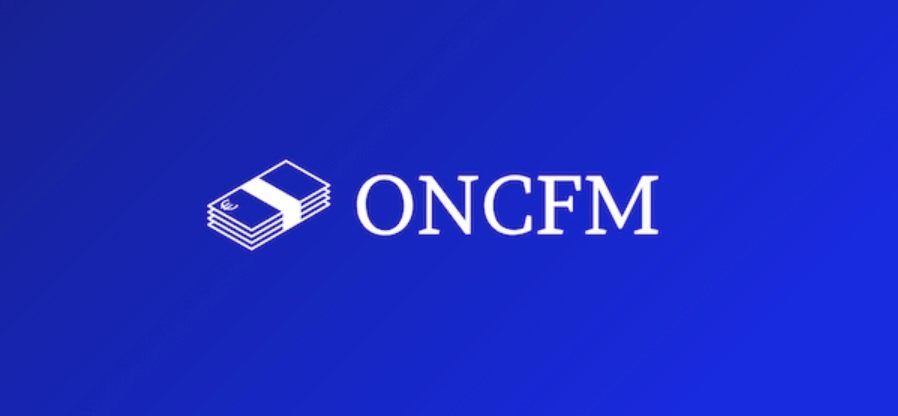


<font size="5">The scenario presented here is that you are a Data Analyst for a French data consulting company that is hired by a French government organisation concerned with detecting fake banknotes ("Organisation nationale de lutte contre le faux-monnayage (ONCFM)").</font>

You are asked to develop a model capable of automatically detecting fake banknotes using certain measurements. The organisation wants you to compare the Logistic regression method with a KMeans method to see which performs better. Any other models are at your own discretion.

There is 1 csv file provided, namely:

1. Example banknotes with the following measurements:
    1. Length
    2. Height Left
    3. Height Right
    4. Margin Up
    5. Margin Low
    6. Diagonal
    
The csv file has details for 1500 banknotes, 1000 of which are real and 500 of which are fake.

When you arrive at the ONCFM a colleague informs you that there is missing data in the file and asks you to use a linear regression to fill in the missing data.

# Import Libraries

In [21]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import missingno as msno

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import metrics, neighbors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from collections import Counter

import xgboost as xgb
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

# First check of the Data

In [3]:
money_data = pd.read_excel(r"Billets examples.xlsx")
money_data.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [4]:
money_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


<AxesSubplot:>

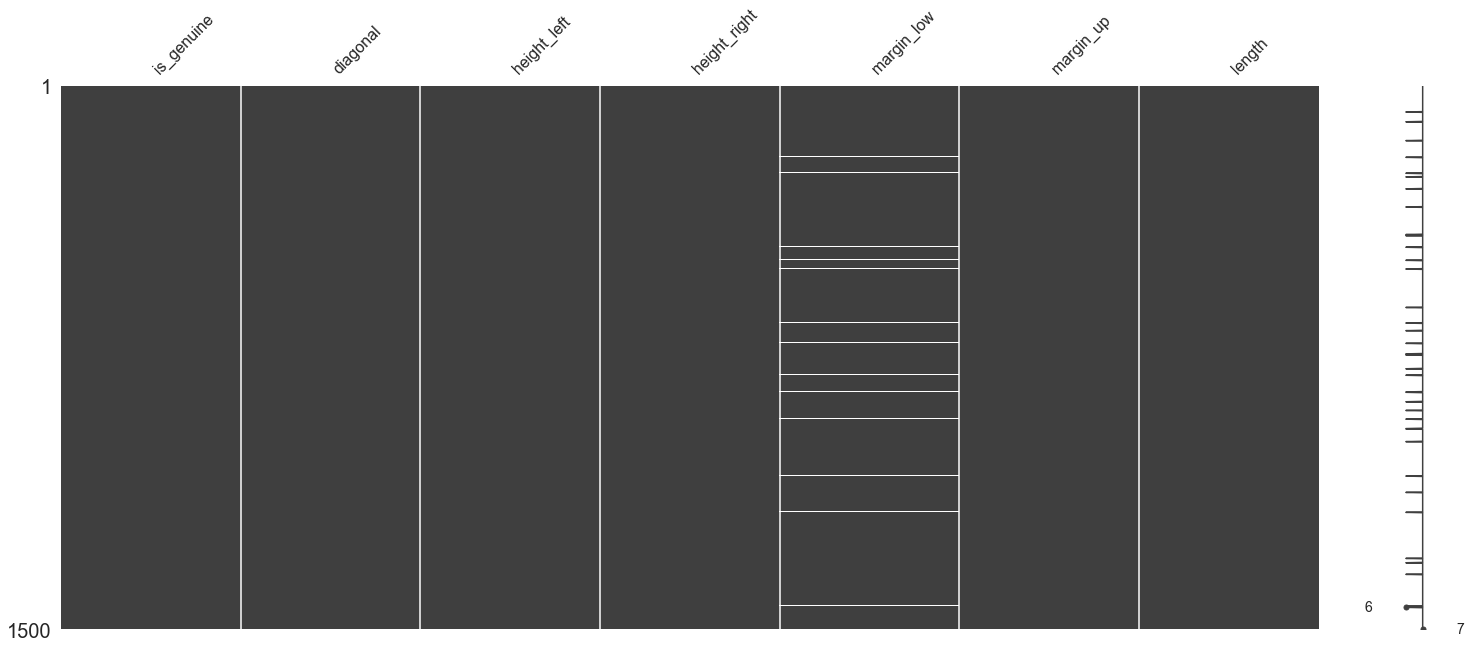

In [5]:
#Confirming the missing values visually
msno.matrix(money_data)

# Dealing with missing values

### Step 1: Separate items with null values as test data

In [6]:
test_data = money_data[money_data["margin_low"].isnull()]
test_data

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,NaN,3.25,112.79
99,True,171.93,104.07,104.18,NaN,3.14,113.08
151,True,172.07,103.80,104.38,NaN,3.02,112.93
197,True,171.45,103.66,103.80,NaN,3.62,113.27
241,True,171.83,104.14,104.06,NaN,3.02,112.36
251,True,171.80,103.26,102.82,NaN,2.95,113.22
284,True,171.92,103.83,103.76,NaN,3.23,113.29
334,True,171.85,103.70,103.96,NaN,3.00,113.36
410,True,172.56,103.72,103.51,NaN,3.12,112.95
413,True,172.30,103.66,103.50,NaN,3.16,112.95


In [7]:
test_data.shape

(37, 7)

### Step 2: Drop rows with null values to create a train dataset

In [8]:
train_data = money_data.dropna()
train_data

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


<AxesSubplot:>

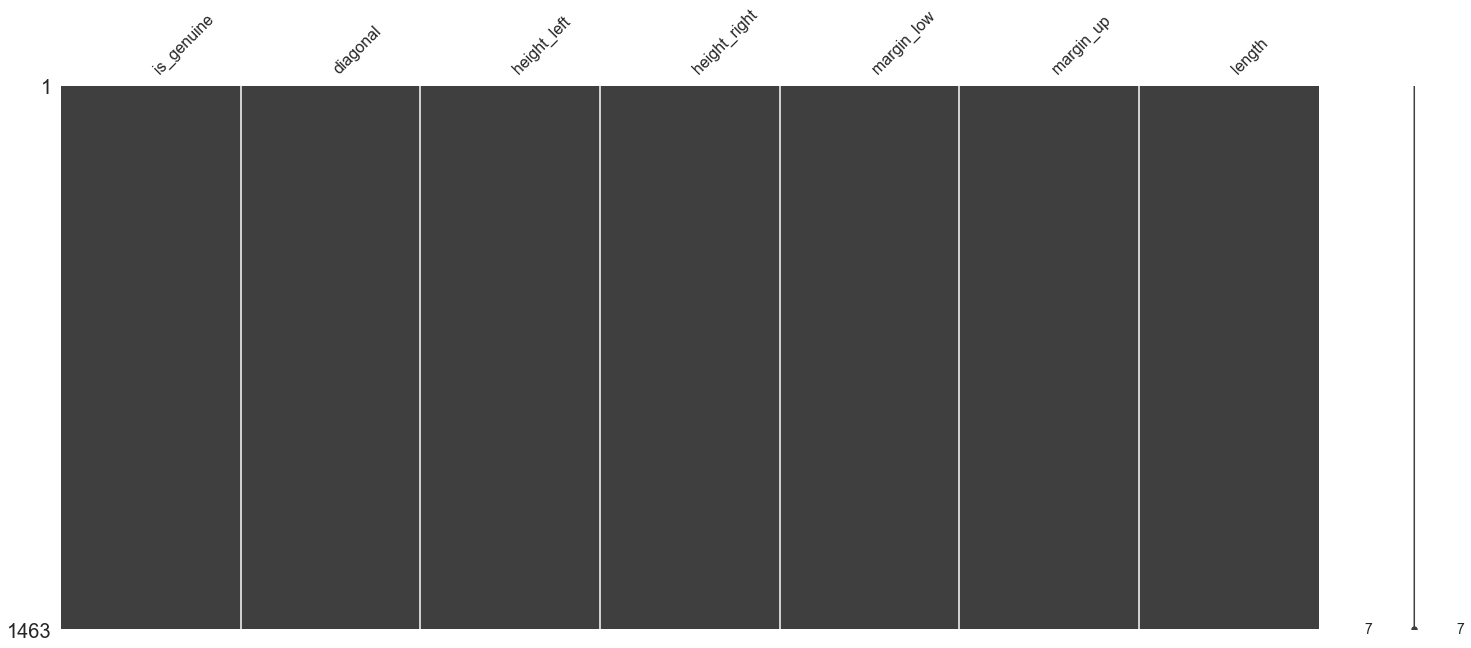

In [9]:
#Checking that there are no more null values visually
msno.matrix(train_data)

### Step 3: Split train data into independent (X) and dependent (y) variables

In [10]:
#The feature with the null values in the full dataset is used as dependent variable
y_train = train_data["margin_low"]
y_train

0       4.52
1       3.77
2       4.40
3       3.62
4       4.04
        ... 
1495    4.42
1496    5.27
1497    5.51
1498    5.17
1499    4.63
Name: margin_low, Length: 1463, dtype: float64

In [11]:
#All other features are used as independent variables
x_train = train_data.drop("margin_low", axis=1)
x_train

,is_genuine,diagonal,height_left,height_right,margin_up,length
0,True,171.81,104.86,104.95,2.89,112.83
1,True,171.46,103.36,103.66,2.99,113.09
2,True,172.69,104.48,103.50,2.94,113.16
3,True,171.36,103.91,103.94,3.01,113.51
4,True,171.73,104.28,103.46,3.48,112.54
...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,3.09,111.28
1496,False,172.19,104.63,104.44,3.37,110.97
1497,False,171.80,104.01,104.12,3.36,111.95
1498,False,172.06,104.28,104.06,3.46,112.25


### Step 4: Train the model

In [14]:
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [15]:
coeff_df = pd.DataFrame(lr.coef_, x_train.columns, columns=['Coefficient'])
coeff_df

,Coefficient
is_genuine,-1.140597
diagonal,-0.013016
height_left,0.028291
height_right,0.026750
margin_up,-0.212844
length,-0.003883


In [16]:
lr.intercept_

2.8668228920543335

In [17]:
#R-squared value for the model
lr.score(x_train, y_train)

0.6168760755671029

### Step 5: Use the model on the test data (data with missing values)

In [18]:
#Create an independent variable dataframe
x_test = test_data.drop("margin_low", axis=1)
x_test

,is_genuine,diagonal,height_left,height_right,margin_up,length
72,True,171.94,103.89,103.45,3.25,112.79
99,True,171.93,104.07,104.18,3.14,113.08
151,True,172.07,103.80,104.38,3.02,112.93
197,True,171.45,103.66,103.80,3.62,113.27
241,True,171.83,104.14,104.06,3.02,112.36
251,True,171.80,103.26,102.82,2.95,113.22
284,True,171.92,103.83,103.76,3.23,113.29
334,True,171.85,103.70,103.96,3.00,113.36
410,True,172.56,103.72,103.51,3.12,112.95
413,True,172.30,103.66,103.50,3.16,112.95


In [19]:
#Apply model on x_test
y_predict = lr.predict(x_test)
y_predict

array([4.06495361, 4.11199026, 4.13400328, 3.99357074, 4.1403993 ,
       4.09428392, 4.07412432, 4.12538999, 4.0807278 , 4.07363322,
       4.11897255, 4.18037978, 4.13648423, 4.05106842, 4.17837685,
       4.22555104, 4.11586845, 4.10284101, 4.08184346, 4.09276238,
       4.11250192, 4.15717623, 4.16028787, 4.12193808, 4.12353555,
       4.19842271, 4.10962313, 4.09696025, 4.13384101, 5.25968515,
       5.264817  , 5.28251853, 5.30206887, 5.20035843, 5.1754678 ,
       5.17345045, 5.24675055])

In [20]:
y_predict.shape

(37,)

### Step 6: Fill missing values with predicted values

In [22]:
test_data.loc[test_data.margin_low.isnull(), "margin_low"] = y_predict
test_data

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,4.064954,3.25,112.79
99,True,171.93,104.07,104.18,4.111990,3.14,113.08
151,True,172.07,103.80,104.38,4.134003,3.02,112.93
197,True,171.45,103.66,103.80,3.993571,3.62,113.27
241,True,171.83,104.14,104.06,4.140399,3.02,112.36
251,True,171.80,103.26,102.82,4.094284,2.95,113.22
284,True,171.92,103.83,103.76,4.074124,3.23,113.29
334,True,171.85,103.70,103.96,4.125390,3.00,113.36
410,True,172.56,103.72,103.51,4.080728,3.12,112.95
413,True,172.30,103.66,103.50,4.073633,3.16,112.95


### Step 7: Create new dataframe with no missing values

In [23]:
money_data_nonull = pd.concat([train_data, test_data], ignore_index=True)
money_data_nonull

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.520000,2.89,112.83
1,True,171.46,103.36,103.66,3.770000,2.99,113.09
2,True,172.69,104.48,103.50,4.400000,2.94,113.16
3,True,171.36,103.91,103.94,3.620000,3.01,113.51
4,True,171.73,104.28,103.46,4.040000,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,172.17,104.49,103.76,5.302069,2.93,111.21
1496,False,172.08,104.15,104.17,5.200358,3.40,112.29
1497,False,171.72,104.46,104.12,5.175468,3.61,110.31
1498,False,172.66,104.33,104.41,5.173450,3.56,111.47


In [24]:
money_data_nonull.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


<AxesSubplot:>

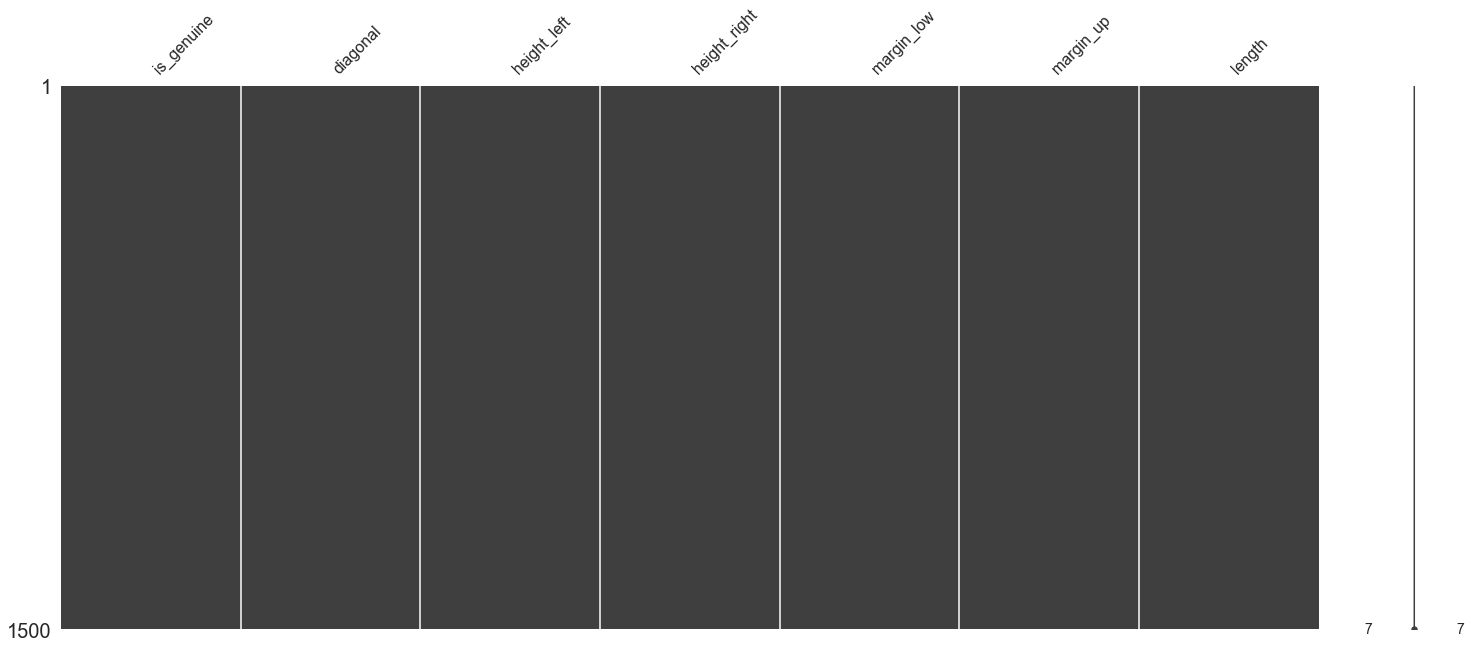

In [25]:
msno.matrix(money_data_nonull)

# Analysing the data

In [26]:
money_data_nonull.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.482844,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.659899,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.027500,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


In [28]:
#Checking if we have indeed 1000 genuine banknotes and 500 fake banknotes
money_data_nonull["is_genuine"].value_counts()

True     1000
False     500
Name: is_genuine, dtype: int64

In [31]:
#Having a look at the feature averages for genuine and fake banknotes
money_data_nonull.groupby("is_genuine").mean()

,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,,,,,,
0,171.90116,104.19034,104.14362,5.216290,3.35016,111.63064
1,171.98708,103.94913,103.80865,4.116122,3.05213,113.20243


<AxesSubplot:xlabel='is_genuine', ylabel='length'>

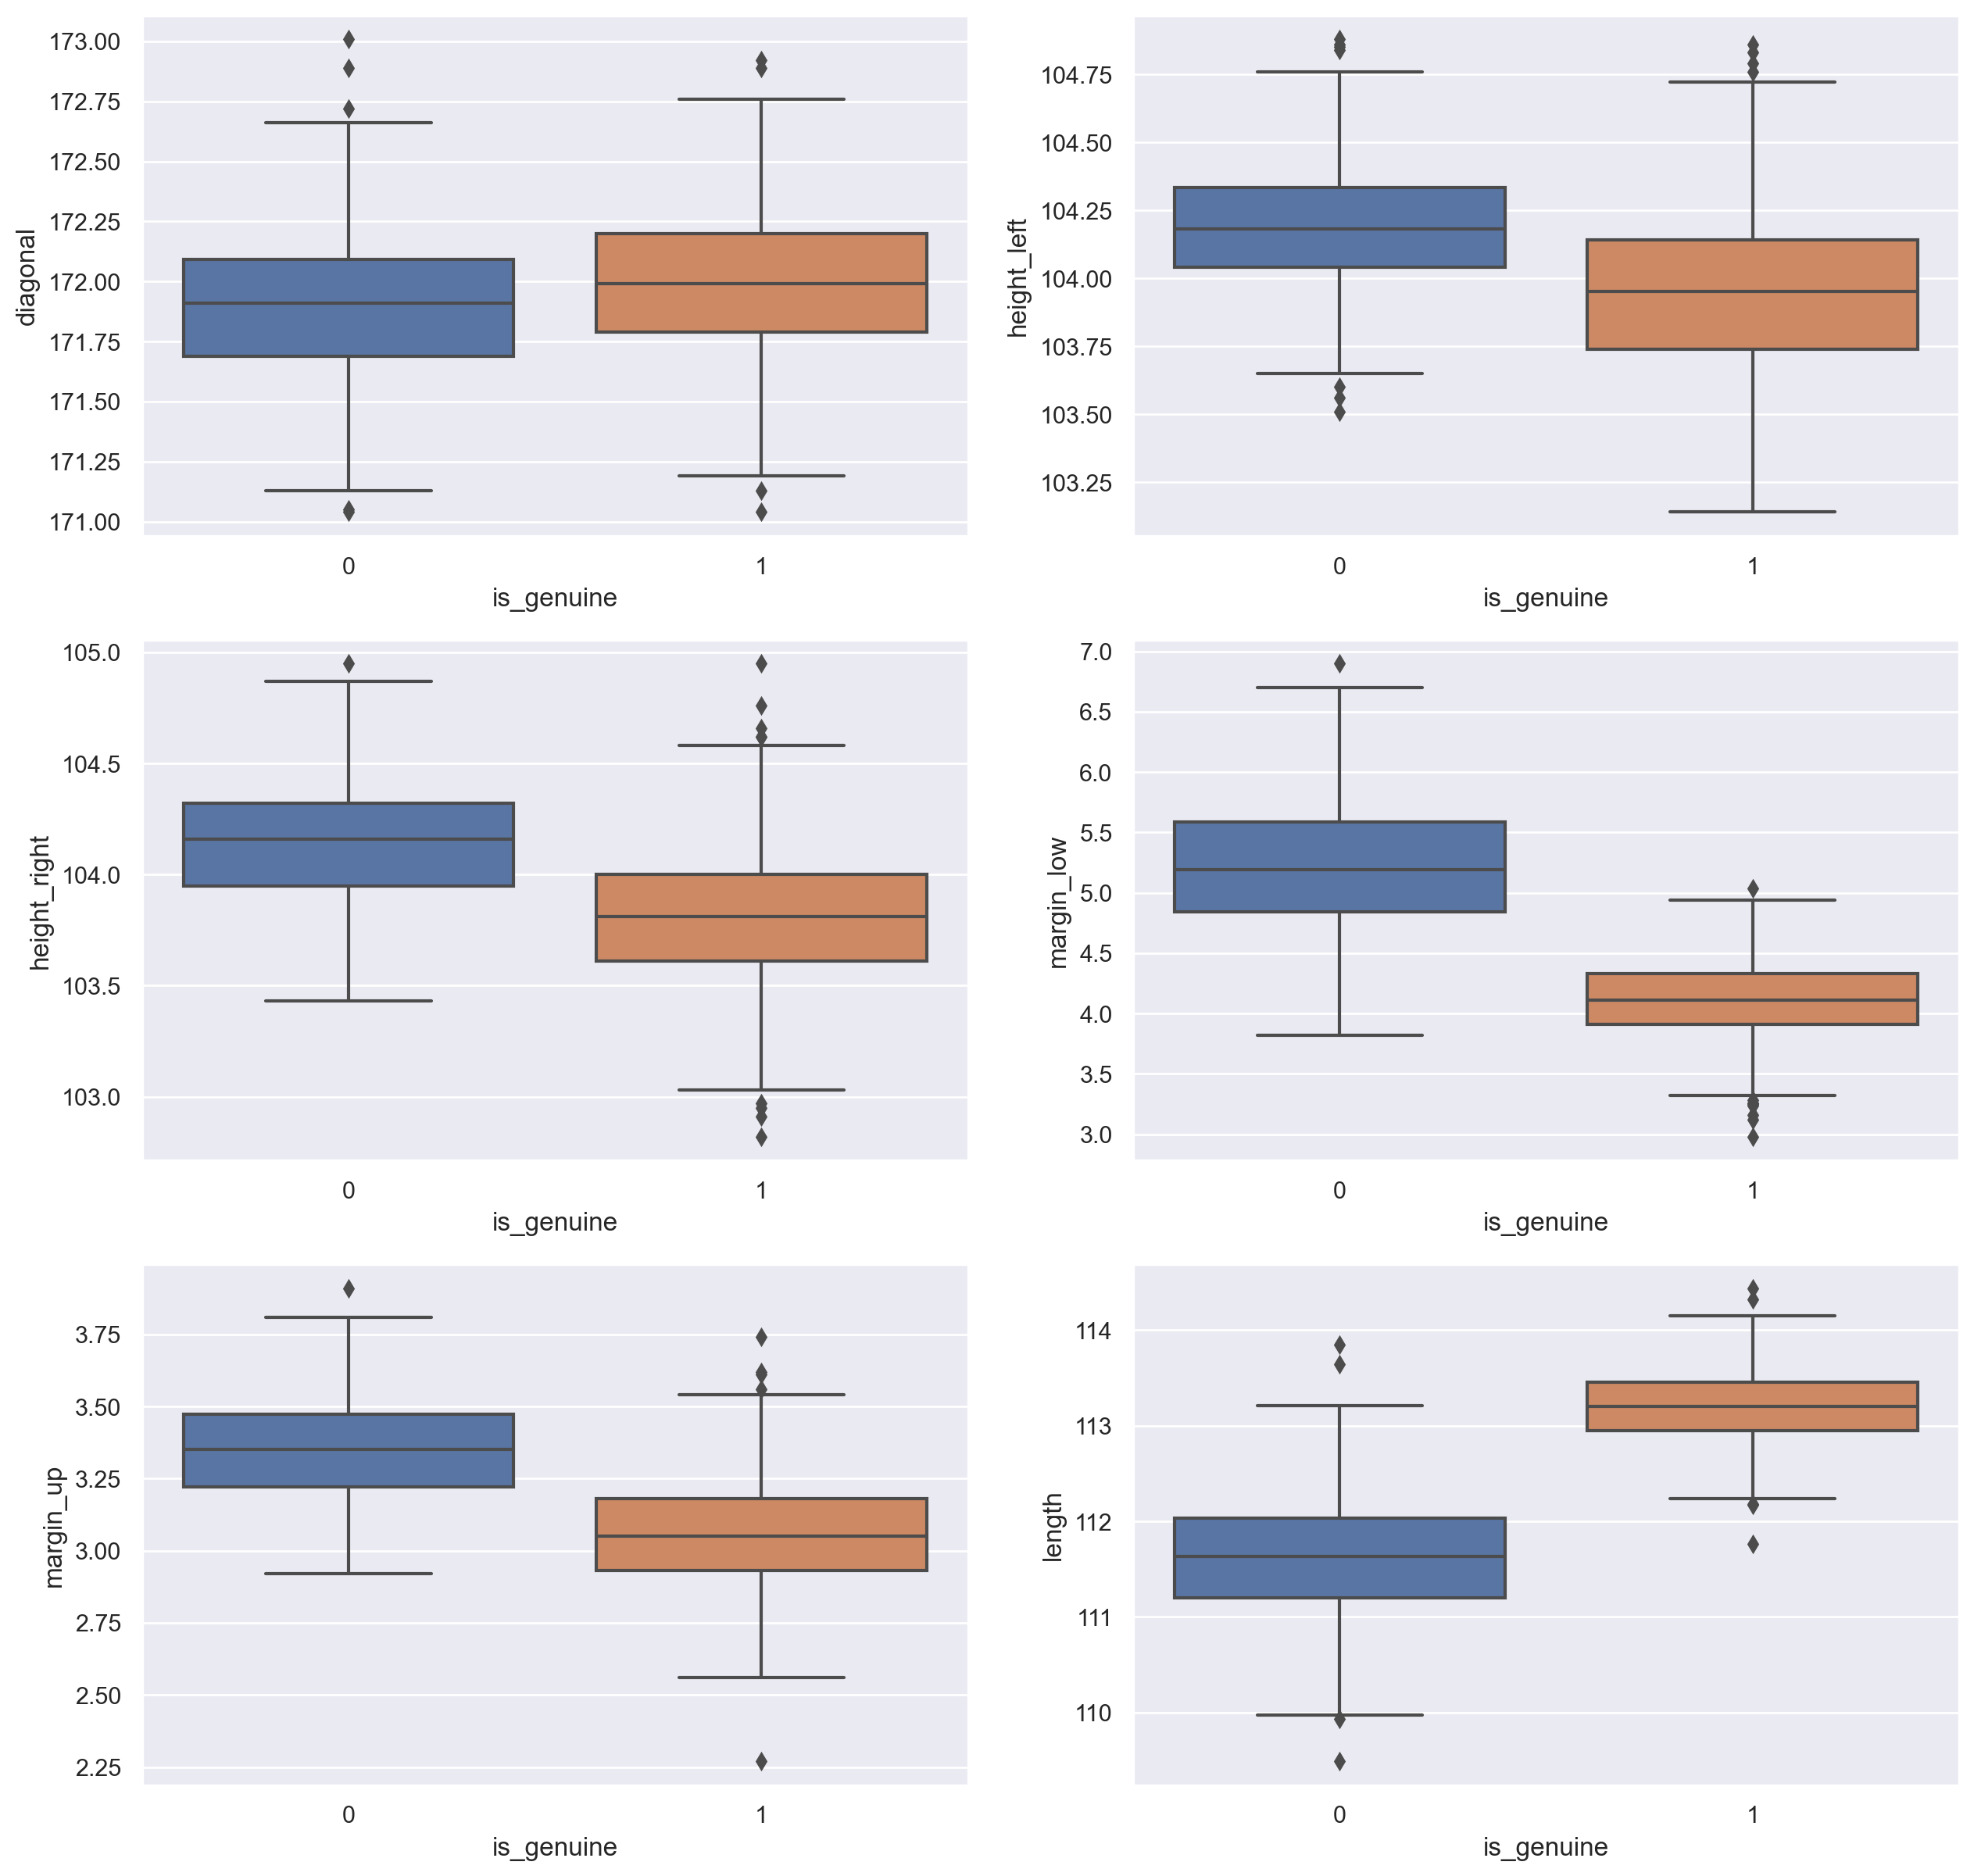

In [32]:
#Visually comparing the data for genuine and fake banknotes
money_data_nonull["is_genuine"] = money_data_nonull["is_genuine"].astype(int)
plt.figure(figsize=(15,15), dpi=200)

plt.subplot(3,2,1)
sns.boxplot(x = 'is_genuine', y = 'diagonal', data = money_data_nonull)

plt.subplot(3,2,2)
sns.boxplot(x = 'is_genuine', y = 'height_left', data = money_data_nonull)

plt.subplot(3,2,3)
sns.boxplot(x = 'is_genuine', y = 'height_right', data = money_data_nonull)

plt.subplot(3,2,4)
sns.boxplot(x = 'is_genuine', y = 'margin_low', data = money_data_nonull)

plt.subplot(3,2,5)
sns.boxplot(x = 'is_genuine', y = 'margin_up', data = money_data_nonull)

plt.subplot(3,2,6)
sns.boxplot(x = 'is_genuine', y = 'length', data = money_data_nonull)

<font color='blue'>We can see from the above boxplots that there is a significant overlap between genuine and false for both the diagonal and height_left features. This is a first indication that these features are not significant to our analysis.</font>

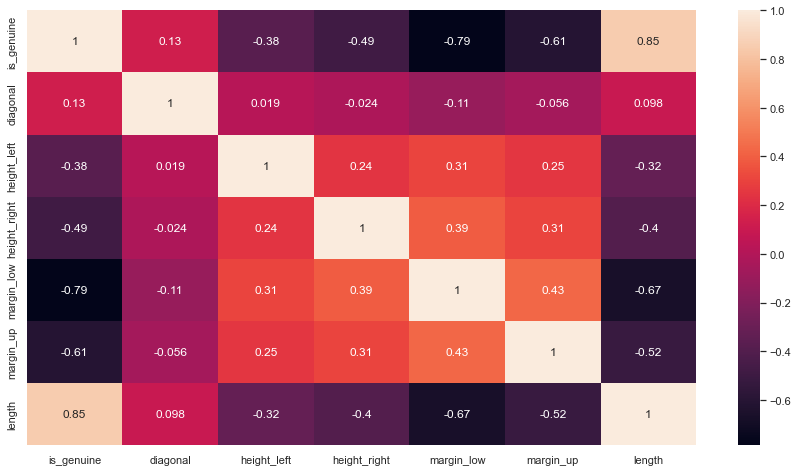

In [33]:
#Checking if there is correlation between the different features
corrMatrix = money_data_nonull.corr()
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(corrMatrix, annot=True)
plt.show()

<font color='blue'>We can see from the above matrix that there is a high positive correlation between length and is_genuine and a relatively high negative correlation between margin_low and is_genuine.</font>

<font color='blue'>There is almost no correlation between diagonal and is_genuine and only minimal negative correlation between height_left and is_genuine. This is a further indication that these two features are likely not significant.</font>

# Preparing data for Machine Learning treatments

In [34]:
#Copy data
data = money_data_nonull.copy()
data

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.520000,2.89,112.83
1,1,171.46,103.36,103.66,3.770000,2.99,113.09
2,1,172.69,104.48,103.50,4.400000,2.94,113.16
3,1,171.36,103.91,103.94,3.620000,3.01,113.51
4,1,171.73,104.28,103.46,4.040000,3.48,112.54
...,...,...,...,...,...,...,...
1495,0,172.17,104.49,103.76,5.302069,2.93,111.21
1496,0,172.08,104.15,104.17,5.200358,3.40,112.29
1497,0,171.72,104.46,104.12,5.175468,3.61,110.31
1498,0,172.66,104.33,104.41,5.173450,3.56,111.47


In [35]:
# declare dependent and independent variables
y = data["is_genuine"]
X = data.drop("is_genuine", axis=1)

In [36]:
# split into train test sets, using stratify to ensure an equal split of genuine and false banknotes between
#train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

y_train.value_counts(), y_test.value_counts()

(1    800
 0    400
 Name: is_genuine, dtype: int64,
 1    200
 0    100
 Name: is_genuine, dtype: int64)

### Testing XGBoost as an alternative model to the 2 models requested

In [54]:
train_xgb_1 = xgb.DMatrix(X_train, label=y_train)
test_xgb_1 = xgb.DMatrix(X_test, label=y_test)

In [55]:
#These parameters can be adjusted but the accuracy of the model doesn't increase beyond 0.99
param = {'max_depth':8, 'eta':0.9, 'objective':'multi:softmax', 'num_class':2}

In [56]:
model = xgb.train(param, train_xgb_1)

In [57]:
# make a prediction
y_pred_xgb = model.predict(test_xgb_1)
metrics.accuracy_score(y_test, y_pred_xgb)

0.99

# Applying Logit regression to data

In [41]:
reg_log = sm.Logit(y_train,X_train)
results_log = reg_log.fit()

Optimization terminated successfully.
         Current function value: 0.026279
         Iterations 12


In [42]:
results_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             is_genuine   No. Observations:                 1200
Model:                          Logit   Df Residuals:                     1194
Method:                           MLE   Df Model:                            5
Date:                Tue, 27 Sep 2022   Pseudo R-squ.:                  0.9587
Time:                        12:11:46   Log-Likelihood:                -31.534
converged:                       True   LL-Null:                       -763.82
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
diagonal        -0.7712      0.817     -0.944      0.345      -2.372       0.829
height_left     -1.4877      1.166     -1.276      0.202      -3.774       0.798
height_right    -3.1211      1.158     -2.696      0.007      -5.390      -0.852
margin_low      -6.3805      1.127     -5.662      0.000      -8.589      -4.172
margin_up      -10.7632      2.538     -4.240      0.000     -15.738      -5.788
length           6.0049      0.985      6.093      0.000       4.073       7.936
================================================================================

Possibly complete quasi-separation: A fraction 0.56 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

<font color='blue'>The P-values of diagonal and height_left are above the 0.05 significance level. They should be removed from the analysis.</font>

### Testing Random Forest Regression as an alternative model

In [43]:
rf = RandomForestRegressor(n_estimators = 1000, oob_score = True, n_jobs = -1, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train);

In [44]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 0.02


In [45]:
rf.score(X_test, y_test)

0.955578955

<font color='blue'>The Random Forest method doesn't give a better result.</font>

In [46]:
feature_list = list(X.columns)
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: length               Importance: 0.83
Variable: margin_low           Importance: 0.12
Variable: margin_up            Importance: 0.03
Variable: height_right         Importance: 0.01
Variable: diagonal             Importance: 0.0
Variable: height_left          Importance: 0.0


<font color='blue'>The above table confirms that the diagonal and height_left features are not significant.</font>

# Create and work with dataframe with statistically significant features

In [48]:
#removing insignificant features
sig_X = X.drop(columns =['diagonal', 'height_left'])
sig_X

,height_right,margin_low,margin_up,length
0,104.95,4.520000,2.89,112.83
1,103.66,3.770000,2.99,113.09
2,103.50,4.400000,2.94,113.16
3,103.94,3.620000,3.01,113.51
4,103.46,4.040000,3.48,112.54
...,...,...,...,...
1495,103.76,5.302069,2.93,111.21
1496,104.17,5.200358,3.40,112.29
1497,104.12,5.175468,3.61,110.31
1498,104.41,5.173450,3.56,111.47


In [49]:
# split into train test sets
sig_X_train, sig_X_test, y_train, y_test = train_test_split(sig_X, y, test_size=0.20, random_state=42, stratify=y)
y_train.value_counts(), y_test.value_counts()

(1    800
 0    400
 Name: is_genuine, dtype: int64,
 1    200
 0    100
 Name: is_genuine, dtype: int64)

### testing XGBoost on the new dataset

In [58]:
train_xgb_2 = xgb.DMatrix(sig_X_train, label=y_train)
test_xgb_2 = xgb.DMatrix(sig_X_test, label=y_test)

In [59]:
param = {'max_depth':8, 'eta':0.9, 'objective':'multi:softmax', 'num_class':2}
model = xgb.train(param, train_xgb_2)

In [60]:
# make a prediction
y_pred_xgb = model.predict(test_xgb_2)
metrics.accuracy_score(y_test, y_pred_xgb)

0.9933333333333333

<font color='blue'>After having removed the 2 insignificant features we get a slightly better result.</font>

In [61]:
confusion_matrix_xgb = metrics.confusion_matrix(y_test, y_pred_xgb)
confusion_matrix_xgb

array([[ 98,   2],
       [  0, 200]], dtype=int64)

<font color='blue'>As we can see from the above matrix the XGBoost model misidentifies 2 items. Both are false positives.</font>
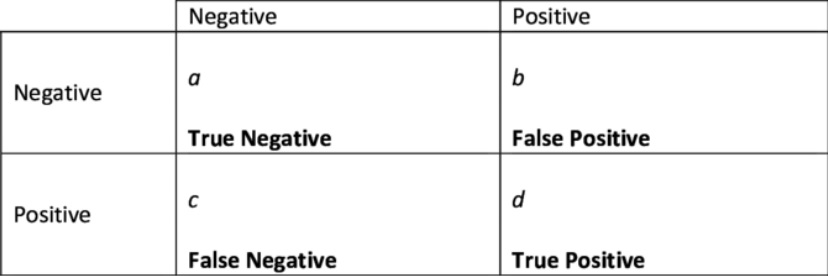

### Using Gridsearch with k Nearest Neighbours and Cross-validation as an alternative method

In [63]:
# fix hyperparametres
param_grid = {'n_neighbors':[3, 5, 7, 9, 11, 13, 15]}

# chose score to optimise
score = 'accuracy'

# Create kNN with hyperparametre optimiser
clf = GridSearchCV(
    neighbors.KNeighborsClassifier(), 
    param_grid,     
    cv=5,           
    scoring=score   
)

# fit kNN to data
clf.fit(sig_X_train, y_train)

# Print optimal hyperparametre
print("Best hyperparametre for training data:")
print(clf.best_params_)

# Print corresponding performance
print("Cross-validation result:")
for mean, std, params in zip(
        clf.cv_results_['mean_test_score'], 
        clf.cv_results_['std_test_score'],  
        clf.cv_results_['params']           
    ):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ) )
    
y_pred_gs = clf.predict(sig_X_test)
print("\nAnd for test data : {:.3f}".format(metrics.accuracy_score(y_test, y_pred_gs)))

Best hyperparametre for training data:
{'n_neighbors': 5}
Cross-validation result:
accuracy = 0.993 (+/-0.006) for {'n_neighbors': 3}
accuracy = 0.993 (+/-0.004) for {'n_neighbors': 5}
accuracy = 0.992 (+/-0.007) for {'n_neighbors': 7}
accuracy = 0.992 (+/-0.007) for {'n_neighbors': 9}
accuracy = 0.991 (+/-0.010) for {'n_neighbors': 11}
accuracy = 0.991 (+/-0.010) for {'n_neighbors': 13}
accuracy = 0.991 (+/-0.010) for {'n_neighbors': 15}

And for test data : 0.990


In [64]:
confusion_matrix_gs = metrics.confusion_matrix(y_test, y_pred_gs)
confusion_matrix_gs

array([[ 97,   3],
       [  0, 200]], dtype=int64)

<font color='blue'>As we can see from the above matrix the GridSearch model misidentifies 3 items. All are false positives.</font>
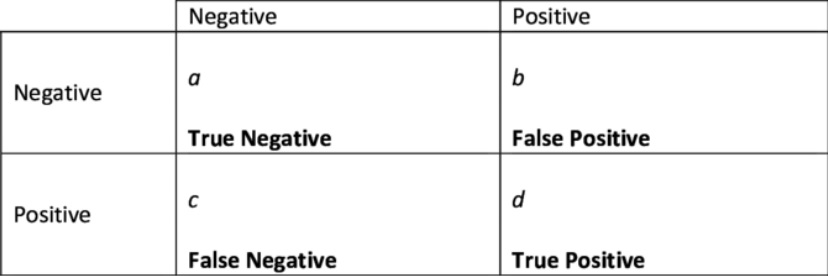

### Scaling the data for Logistic regression and KMeans modeling

In [65]:
scaled_data = StandardScaler().fit_transform(sig_X)
np.mean(scaled_data),np.std(scaled_data)

(-7.119638212316204e-15, 1.0)

In [66]:
# split into train test sets
sig_X_train, sig_X_test, y_train, y_test = train_test_split(scaled_data, y, test_size=0.20, random_state=42, stratify=y)
y_train.value_counts(), y_test.value_counts()

(1    800
 0    400
 Name: is_genuine, dtype: int64,
 1    200
 0    100
 Name: is_genuine, dtype: int64)

### Applying Logistic regression to scaled data

In [55]:
logreg = LogisticRegression()
logreg.fit(sig_X_train, y_train)

LogisticRegression()

In [56]:
y_pred = logreg.predict(sig_X_test)
print('Accuracy of logistic regression on test set: {:.2f}'.format(logreg.score(sig_X_test, y_test)))

Accuracy of logistic regression on test set: 0.99


In [57]:
confusion_matrix_log_reg = metrics.confusion_matrix(y_test, y_pred)
confusion_matrix_log_reg

array([[ 97,   3],
       [  0, 200]], dtype=int64)

<font color='blue'>As we can see from the above matrix the Logistic Regression model misidentifies 3 items. All are false positives.</font>
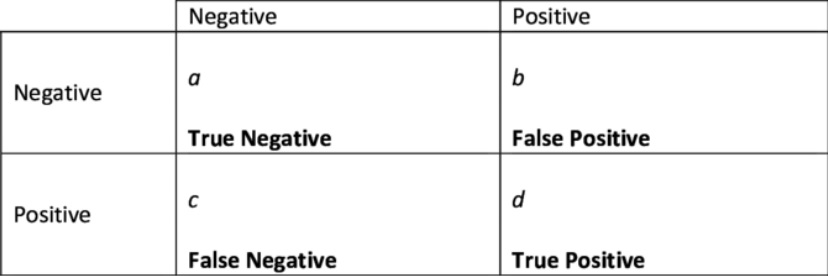

### KMeans analysis

In [67]:
#Performing KMeans clustering using the appropriate number of Clusters, i.e. 2 (genuine and false)
kmeans = KMeans(n_clusters = 2, init = "k-means++", random_state = 42)
kmeans.fit(scaled_data)

KMeans(n_clusters=2, random_state=42)

In [68]:
data["is_genuine"] = data["is_genuine"].astype(int)
data["Kmeans_segment"] = kmeans.labels_
data

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,Kmeans_segment
0,1,171.81,104.86,104.95,4.520000,2.89,112.83,0
1,1,171.46,103.36,103.66,3.770000,2.99,113.09,1
2,1,172.69,104.48,103.50,4.400000,2.94,113.16,1
3,1,171.36,103.91,103.94,3.620000,3.01,113.51,1
4,1,171.73,104.28,103.46,4.040000,3.48,112.54,1
...,...,...,...,...,...,...,...,...
1495,0,172.17,104.49,103.76,5.302069,2.93,111.21,0
1496,0,172.08,104.15,104.17,5.200358,3.40,112.29,0
1497,0,171.72,104.46,104.12,5.175468,3.61,110.31,0
1498,0,172.66,104.33,104.41,5.173450,3.56,111.47,0


In [71]:
#Comparing is_genuine to KMeans segmentation
data['comparison'] = data['is_genuine'] == data['Kmeans_segment']
data

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,Kmeans_segment,comparison
0,1,171.81,104.86,104.95,4.520000,2.89,112.83,0,False
1,1,171.46,103.36,103.66,3.770000,2.99,113.09,1,True
2,1,172.69,104.48,103.50,4.400000,2.94,113.16,1,True
3,1,171.36,103.91,103.94,3.620000,3.01,113.51,1,True
4,1,171.73,104.28,103.46,4.040000,3.48,112.54,1,True
...,...,...,...,...,...,...,...,...,...
1495,0,172.17,104.49,103.76,5.302069,2.93,111.21,0,True
1496,0,172.08,104.15,104.17,5.200358,3.40,112.29,0,True
1497,0,171.72,104.46,104.12,5.175468,3.61,110.31,0,True
1498,0,172.66,104.33,104.41,5.173450,3.56,111.47,0,True


In [82]:
print(data["comparison"].value_counts())

True     1479
False      21
Name: comparison, dtype: int64


In [75]:
#Identifying the misidentified banknotes
data.loc[data['comparison'] == False]

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,Kmeans_segment,comparison
0,1,171.81,104.86,104.95,4.52000,2.89,112.83,0,False
38,1,172.00,103.76,104.27,4.42000,3.29,112.67,0,False
333,1,171.90,104.21,104.21,4.77000,3.38,113.20,0,False
431,1,171.93,103.88,104.35,4.26000,3.29,112.70,0,False
578,1,171.67,103.81,103.76,4.59000,3.30,112.18,0,False
711,1,171.94,104.11,104.16,4.08000,3.35,111.76,0,False
996,0,172.17,104.20,104.13,3.86000,3.38,112.44,1,False
1033,0,171.65,104.19,103.96,5.37000,2.99,112.86,1,False
1044,0,172.13,103.67,103.82,4.27000,3.22,112.15,1,False
1053,0,171.85,103.60,103.82,4.60000,3.21,112.50,1,False


In [83]:
#Calculating accuracy score
print("The accuracy score for KMeans analysis is: ", len(data.loc[data['comparison'] == True])/len(data))

The accuracy score for KMeans analysis is:  0.986


In [74]:
contingency_matrix = pd.crosstab(data['is_genuine'], data['Kmeans_segment'])
contingency_matrix

Kmeans_segment,0,1
is_genuine,,
0,486,14
1,7,993


<font color='blue'>While we must bear in mind that KMeans is the only method used where the whole dataset is analysed, we can see from the above matrix the KMeans model misidentifies 21 items (14 false positives and 7 false negatives) which gives it an accuracy score of 0.986.</font>
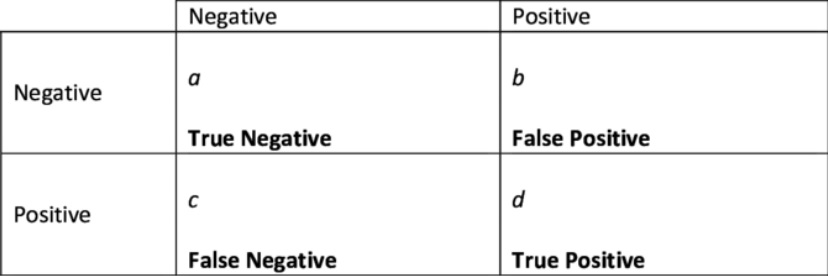

# Conclusion and recommendations

### Both methods are extremely accurate, with 99% accuracy for Logistic Regression and 98.6% accuracy for KMeans analysis.
### In the context of the project I would recommend Logistic regression over KMeans analysis because of its higher accuracy.
### With all methods we saw more false positives than false negatives, meaning we identify false banknotes as genuine. This is a concern.

#### Recommendations:
1. Research other, more powerful methods. As shown above, XGBoost has an even higher accuracy.
2. Investigate other features that could be added to the analysis to improve its accuracy. Two of the six features provided turned out not to be significant which led to an analysis based on only four features.